## Vehicle Detection Project
---
The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.
---

### Import Statements

In [1]:
from skimage.feature import hog

In [2]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

In [3]:
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [4]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import cv2
import glob
import time

%matplotlib inline

In [5]:
from PIL import Image

### Load Training Data

In [6]:
#car_images = glob.glob('dataset/vehicles/Combined/*.jpg')
#for images in car_images:
#    print (images)
#    im = Image.open(images)
#    im2 = im.resize((64,  64), Image.BICUBIC)
#    im2.save(images.replace("jpg", "png"))


In [7]:
car_images = glob.glob('dataset/vehicles/Combined/*.png')
noncar_images = glob.glob('dataset/non-vehicles/**/*.png')
print(len(car_images), len(noncar_images))

1998 8969


### Visualize Some of the Data

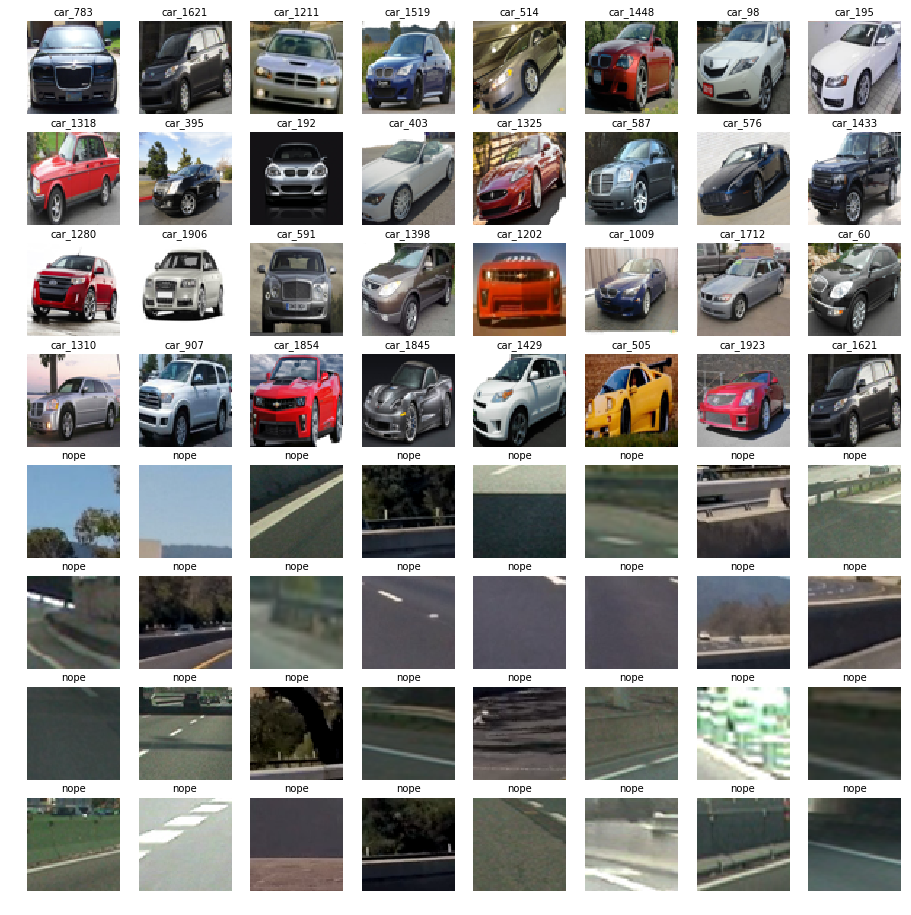

In [8]:
fig, axs = plt.subplots(8,8, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Step through the list and search for chessboard corners
for i in np.arange(32):
    idx = np.random.randint(0,len(car_images))
    img = cv2.imread(car_images[idx])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('car_{}'.format(idx), fontsize=10)
    axs[i].imshow(img)
for i in np.arange(32,64):
    img = cv2.imread(noncar_images[np.random.randint(0,len(noncar_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('nope', fontsize=10)
    axs[i].imshow(img)

### Define Method to Convert Image to Histogram of Oriented Gradients (HOG)

In [9]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec, block_norm='L2-Hys')
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec, block_norm='L2-Hys')
        return features


Visualize HOG on example image

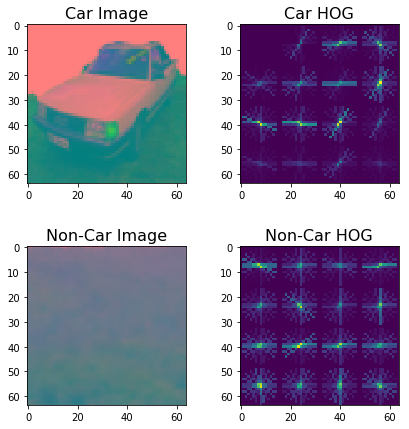

In [10]:
car_img = mpimg.imread(car_images[5])
orientations=11
pixels_per_cell=16
cells_per_block=2
feature_car_image = cv2.cvtColor(car_img, cv2.COLOR_RGB2YUV) # Can be GRAY, RGB, HSV, LUV, HLS, YUV, YCrCb

# feature_car_image[:,:,2]
_, car_dst = get_hog_features(feature_car_image[:,:,0], orientations, pixels_per_cell, cells_per_block, vis=True, feature_vec=True)
noncar_img = mpimg.imread(noncar_images[5])
feature_noncar_image = cv2.cvtColor(noncar_img, cv2.COLOR_RGB2YUV) 

_, noncar_dst = get_hog_features(feature_noncar_image[:,:,1], orientations, pixels_per_cell, cells_per_block, vis=True, feature_vec=True)

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)

ax1.imshow(feature_car_image, cmap='gray')
ax1.set_title('Car Image', fontsize=16)

ax2.imshow(car_dst)
ax2.set_title('Car HOG', fontsize=16)

ax3.imshow(feature_noncar_image, cmap='gray')
ax3.set_title('Non-Car Image', fontsize=16)

ax4.imshow(noncar_dst)
ax4.set_title('Non-Car HOG', fontsize=16)


### Method to Extract HOG Features from an Array of Car and Non-Car Images
*The code for this method was mostly duplicated from course lesson material.*

In [11]:
# Define a function to extract features from a list of image locations
# This function could also be used to call bin_spatial() and color_hist() (as in the lessons) to extract
# flattened spatial color features and color histogram features and combine them all (making use of StandardScaler)
# to be used together for classification
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    ignore_images = 0
    accept_images = 0
    # Iterate through the list of images
    for file in imgs:
        #print("Processing file:", file)
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
            elif cspace == 'GRAY':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)         
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if (len(feature_image.shape) > 2):
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                
        else:
            hog_features = get_hog_features(feature_image, orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            
        # Append the new feature vector to the features list
        if(hog_features.shape[0] != 1188):
            print("Ignoring ", file, hog_features.shape[0])
            ignore_images +=1
        else:
            features.append(hog_features)
            accept_images +=1
            
    print("Total Images ignored: ", ignore_images, hog_features.shape[0])
    print("Total Images accepted: ", accept_images, hog_features.shape[0])

    for f in features:
        if (f.shape[0] != 1188):
            print('Found issue')
    
    # Return list of feature vectors
    return features

### Extract Features for Input Datasets and Combine, Define Labels Vector, Shuffle and Split

In [12]:
# Feature extraction parameters
colorspace = 'RGB' # Can be GRAY, RGB, HSV, LUV, HLS, YUV, YCrCb
orient = orientations
pix_per_cell = pixels_per_cell
cell_per_block = cells_per_block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t = time.time()
car_features = extract_features(car_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(noncar_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
for c,n in zip(car_features, notcar_features):
    X = np.vstack((c,n))
X = np.vstack((car_features, notcar_features)).astype(np.float64)  

# Fit a per-column scaler - this will be necessary if combining different types of features (HOG + color_hist/bin_spatial)
#X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
#scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))


Ignoring  dataset/vehicles/Combined/39.png 337392
Ignoring  dataset/vehicles/Combined/5.png 51744
Ignoring  dataset/vehicles/Combined/17.png 4224
Ignoring  dataset/vehicles/Combined/37.png 120120
Ignoring  dataset/vehicles/Combined/42.png 221760
Ignoring  dataset/vehicles/Combined/03469.png 396
Ignoring  dataset/vehicles/Combined/41.png 74052
Ignoring  dataset/vehicles/Combined/35.png 11088
Ignoring  dataset/vehicles/Combined/6.png 51744
Ignoring  dataset/vehicles/Combined/8.png 62832
Ignoring  dataset/vehicles/Combined/1.png 51744
Ignoring  dataset/vehicles/Combined/12.png 12936
Ignoring  dataset/vehicles/Combined/47.png 54912
Ignoring  dataset/vehicles/Combined/19.png 80784
Ignoring  dataset/vehicles/Combined/67.png 11088
Ignoring  dataset/vehicles/Combined/33.png 1492920
Ignoring  dataset/vehicles/Combined/63.png 92400
Ignoring  dataset/vehicles/Combined/22.png 11880
Ignoring  dataset/vehicles/Combined/3.png 51744
Ignoring  dataset/vehicles/Combined/38.png 744480
Ignoring  dataset/v

**Parameter exploration**

| Configuration Label | Colorspace | Orientations | Pixels Per Cell | Cells Per Block | HOG Channel | Extract Time |
| :-----------------: | :--------: | :----------: | :-------------: | :-------------: | :---------: | ------------:|
| 1                   | RGB        | 9            | 8               | 2               | ALL         | 71.16        |
| 2                   | HSV        | 9            | 8               | 2               | 1           | 43.74        |
| 3                   | HSV        | 9            | 8               | 2               | 2           | 36.35        |
| 4                   | LUV        | 9            | 8               | 2               | 0           | 37.42        |
| 5                   | LUV        | 9            | 8               | 2               | 1           | 38.34        |
| 6                   | HLS        | 9            | 8               | 2               | 0           | 37.42        |
| 7                   | HLS        | 9            | 8               | 2               | 1           | 42.04        |
| 8                   | YUV        | 9            | 8               | 2               | 0           | 35.86        |
| 9                   | YCrCb      | 9            | 8               | 2               | 1           | 38.32        |
| 10                  | YCrCb      | 9            | 8               | 2               | 2           | 38.99        |
| 11                  | HSV        | 9            | 8               | 2               | ALL         | 79.72        |
| 12                  | LUV        | 9            | 8               | 2               | ALL         | 78.57        |
| 13                  | HLS        | 9            | 8               | 2               | ALL         | 81.37        |
| 14                  | YUV        | 9            | 8               | 2               | ALL         | 81.82        |
| 15                  | YCrCb      | 9            | 8               | 2               | ALL         | 79.05        |
| 16                  | YUV        | 9            | 8               | 1               | 0           | 44.04        |
| 17                  | YUV        | 9            | 8               | 3               | 0           | 37.74        |
| 18                  | YUV        | 6            | 8               | 2               | 0           | 37.12        |
| 19                  | YUV        | 12           | 8               | 2               | 0           | 40.11        |
| 20                  | YUV        | 11           | 8               | 2               | 0           | 38.01        |
| 21                  | YUV        | 11           | 16              | 2               | 0           | 30.21        |
| 22                  | YUV        | 11           | 12              | 2               | 0           | 30.33        |
| 23                  | YUV        | 11           | 4               | 2               | 0           | 69.08        |
| 24                  | YUV        | 11           | 16              | 2               | ALL         | 55.20        |
| 25                  | YUV        | 7            | 16              | 2               | ALL         | 53.18        |


### Train a Classifier

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam
from keras import utils

Using TensorFlow backend.


In [14]:
no_of_features = 1188
y_train_oh = utils.to_categorical(y_train, num_classes=2)
y_test_oh = utils.to_categorical(y_test, num_classes=2)

In [15]:
print("Training Data shape", X_train.shape, "; Output label shape", y_train_oh.shape)

Training Data shape (5448, 1188) ; Output label shape (5448, 2)


In [16]:
print("Testing Data shape", X_test.shape, "; Output label shape", y_test_oh.shape)

Testing Data shape (5448, 1188) ; Output label shape (5448, 2)


In [17]:
# Use a FCN 

model = Sequential()
# Dense(1188) is a fully-connected layer with 64 hidden units.

model.add(Dense(X_train.shape[1], activation='relu', input_dim=X_train.shape[1]))
#model.add(Dropout(0.5))
model.add(Dense(int(X_train.shape[1]), activation='relu'))
model.add(Dense(int(X_train.shape[1] * 0.5), activation='relu'))


#model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

opt = Adam(lr=0.00001) #lr=0.00001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# Check the training time

t = time.time()
model.fit(X_train, y_train_oh,epochs=10, batch_size=100, validation_split=0.2)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train FCN...')


Train on 4358 samples, validate on 1090 samples
Epoch 1/10
4358/4358 [==============================] - 4s - loss: 0.5111 - acc: 0.7880 - val_loss: 0.2019 - val_acc: 0.8780
Epoch 2/10
4358/4358 [==============================] - 2s - loss: 0.1750 - acc: 0.9339 - val_loss: 0.1337 - val_acc: 0.9560
Epoch 3/10
4358/4358 [==============================] - 2s - loss: 0.1254 - acc: 0.9631 - val_loss: 0.1014 - val_acc: 0.9688
Epoch 4/10
4358/4358 [==============================] - 2s - loss: 0.0982 - acc: 0.9732 - val_loss: 0.0817 - val_acc: 0.9743
Epoch 5/10
4358/4358 [==============================] - 2s - loss: 0.0782 - acc: 0.9805 - val_loss: 0.0692 - val_acc: 0.9780
Epoch 6/10
4358/4358 [==============================] - 2s - loss: 0.0636 - acc: 0.9849 - val_loss: 0.0593 - val_acc: 0.9807
Epoch 7/10
4358/4358 [==============================] - 2s - loss: 0.0527 - acc: 0.9885 - val_loss: 0.0522 - val_acc: 0.9826
Epoch 8/10
4358/4358 [==============================] - 2s - loss: 0.0448 - a

In [18]:
# Check the score of the SVC
score = model.evaluate(X_test, y_test_oh, batch_size=128)
print('Test Accuracy of SVC = ', score)

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('Example FCN predicts: ', np.argmax(model.predict(X_test[0:n_predict]), axis = 1))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()

print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with FCN')

5448/5448 [==============================] - 0s     
Test Accuracy of SVC =  [0.040831141151958274, 0.98917033756356931]
Example FCN predicts:  [0 0 0 0 0 0 0 1 0 0]
For these 10 labels:  [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
0.01565 Seconds to predict 10 labels with FCN


### Method for Using Classifier to Detect Cars in an Image

In [19]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    
    # array of rectangles where cars were detected
    rectangles = []
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
        elif cspace == 'GRAY':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2GRAY)
    else: ctrans_tosearch = np.copy(img_tosearch)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    elif hog_channel == 'GRAY':
        ch1 = ctrans_tosearch
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64

    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    for xb in range(5, nxsteps-10):
       
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            ################ ONLY FOR BIN_SPATIAL AND COLOR_HIST ################

            # Extract the image patch
            #subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            #spatial_features = bin_spatial(subimg, size=spatial_size)
            #hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            #test_prediction = svc.predict(test_features)
            
            ######################################################################
            
            hog_features = hog_features.reshape(-1, no_of_features)
            test_prediction = np.argmax(svc.predict(hog_features), axis = 1)
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles
    

### Method to Draw Rectangles onto an Image

In [20]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

### Show All Potential Search Areas

Becuase the size and position of cars in the image will be different depending on their distance from the camera, `find_cars` will have to be called a few times with different `ystart`, `ystop`, and `scale` values. These next few blocks of code are for determining the values for these parameters that work best.

Number of boxes:  18


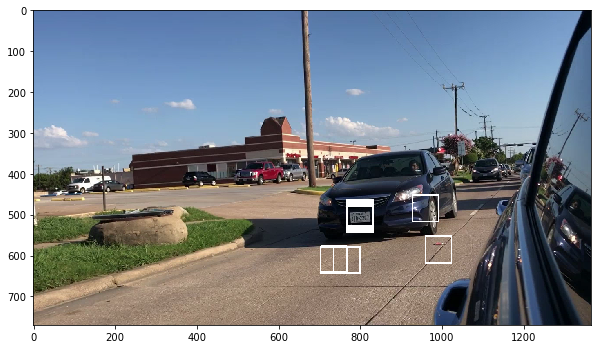

In [21]:
test_img = mpimg.imread('./test_images/BlindSpotHD1.png')

rects = []

ystart = 450
ystop = 550
scale = 1

for i in range(0,100,2):
    #ystart += i
    #ystop += i
    rects.append(find_cars(test_img, ystart+i, ystop+i, scale, colorspace, hog_channel, model, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=False))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

Number of boxes:  126


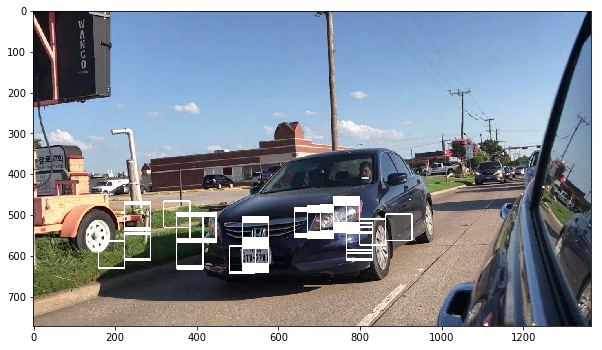

In [22]:
test_img = mpimg.imread('./test_images/BlindSpotHD2.png')

rects = []

ystart = 450
ystop = 550
scale = 1

for i in range(0,100,2):
    #ystart += i
    #ystop += i
    rects.append(find_cars(test_img, ystart+i, ystop+i, scale, colorspace, hog_channel, model, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=False))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

Number of boxes:  155


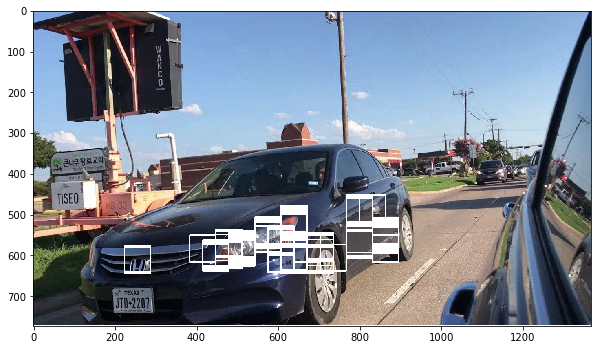

In [23]:
test_img = mpimg.imread('./test_images/BlindSpotHD3.png')

rects = []

ystart = 450
ystop = 550
scale = 1

for i in range(0,100,2):
    #ystart += i
    #ystop += i
    rects.append(find_cars(test_img, ystart+i, ystop+i, scale, colorspace, hog_channel, model, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=False))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

Number of boxes:  68


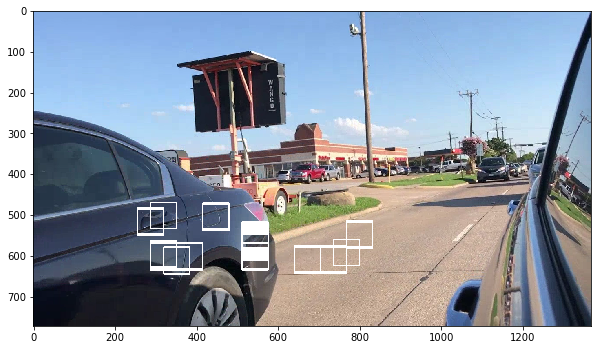

In [24]:
test_img = mpimg.imread('./test_images/BlindSpotHD4.png')

rects = []

ystart = 450
ystop = 550
scale = 1

for i in range(0,100,2):
    #ystart += i
    #ystop += i
    rects.append(find_cars(test_img, ystart+i, ystop+i, scale, colorspace, hog_channel, model, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=False))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

Number of boxes:  57


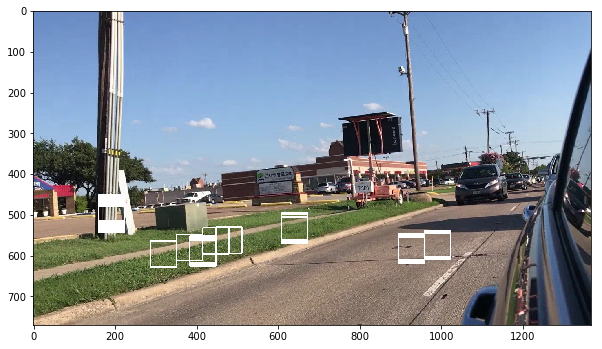

In [25]:
test_img = mpimg.imread('./test_images/BlindSpotHD5.png')

rects = []

ystart = 450
ystop = 550
scale = 1

for i in range(0,100,2):
    #ystart += i
    #ystop += i
    rects.append(find_cars(test_img, ystart+i, ystop+i, scale, colorspace, hog_channel, model, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=False))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

Number of boxes:  57


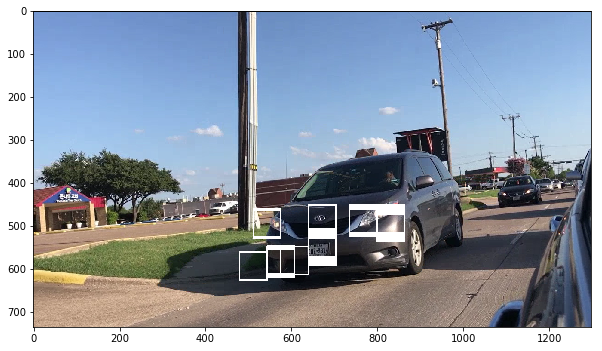

In [26]:
test_img = mpimg.imread('./test_images/BlindSpotHD6.png')

rects = []

ystart = 450
ystop = 550
scale = 1

for i in range(0,100,2):
    #ystart += i
    #ystop += i
    rects.append(find_cars(test_img, ystart+i, ystop+i, scale, colorspace, hog_channel, model, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=False))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

### Combine Various Sliding Window Searches

*Exploration findings:* 
- A scale of less than 1.0 seemed to produce a lot of false positives. 
- The start and stop positions and scales used may need some tweaking in the future, depending on video performance.

### Heatmap
This method (duplicated from lesson material) produces a heat map based on rectangle locations (additive with overlap).

In [27]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

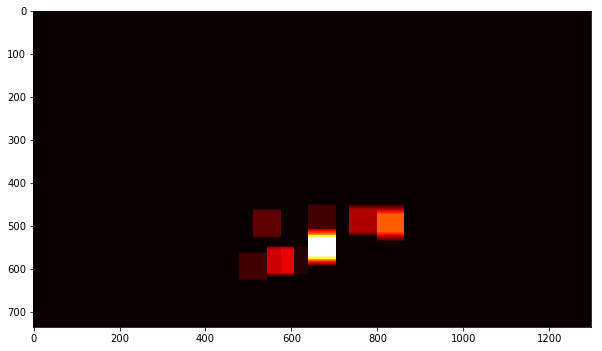

In [28]:
# Test out the heatmap
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

### Apply a Threshold to the Heatmap

In [29]:
threshold = 10
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [30]:
heatmap_img.max()

24.0

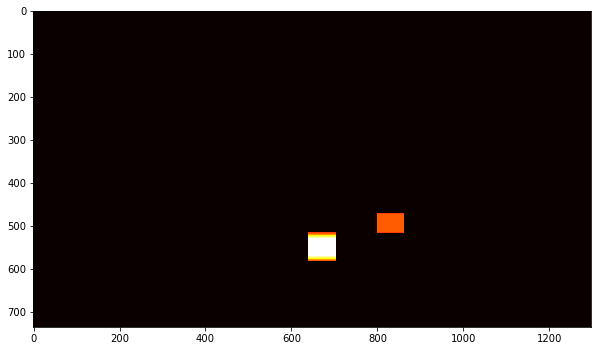

In [31]:
heatmap_img = apply_threshold(heatmap_img.copy(), threshold)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

### Apply SciPy Labels to Heatmap

2 cars found


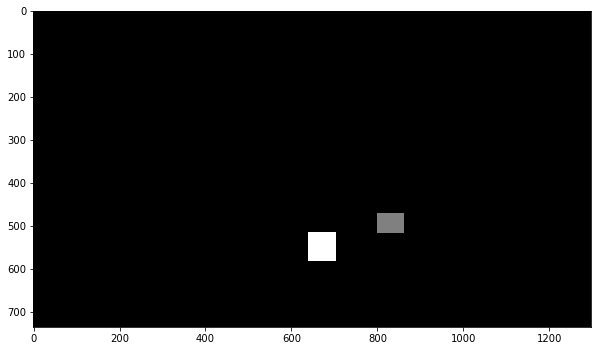

In [32]:
labels = label(heatmap_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

### Draw Bounding Boxes for Lables

Area:  2835
Area:  4221


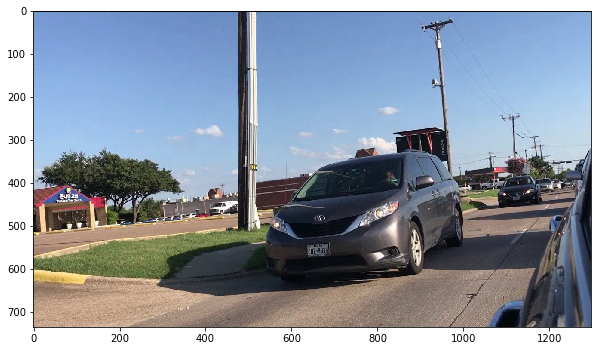

In [33]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        height = bbox[1][1] - bbox[0][1]
        lenght = bbox[1][0] - bbox[0][0]
        area = lenght * height 
        # Draw the box on the image
        print ("Area: ", area)
        if("areas" in locals()):
            areas.append(area)
        if (area > 15000):
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

### Put it All Together

In [34]:
def process_frame(img):

    rectangles = []
    global colorspace
    #colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = orientations
    pix_per_cell = pixels_per_cell
    cell_per_block = cells_per_block
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

    ystart = 450
    ystop = 550
    scale = 1.0

    for i in range(0,100,2):
        #ystart += i
        #ystop += i
        rectangles.append(find_cars(test_img, ystart+i, ystop+i, scale, colorspace, hog_channel, model, None, 
                           orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=False))
    
    rectangles = [item for sublist in rectangles for item in sublist] 
    
    heatmap_img = np.zeros_like(img[:,:,0])
    
    heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img, threshold)
    
    labels = label(heatmap_img)
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

Run the pipeline on all the test images.

Area:  2835
Area:  4221
Area:  2835
Area:  4221
Area:  2835
Area:  4221
Area:  2835
Area:  4221
Area:  2835
Area:  4221
Area:  2835
Area:  4221
Area:  2835
Area:  4221
Area:  2835
Area:  4221


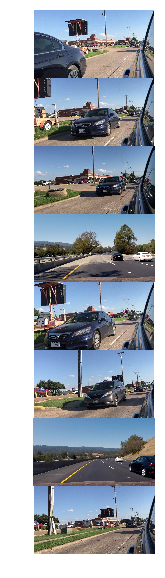

In [35]:
test_images = glob.glob('./test_images/*.*')

fig, axs = plt.subplots(8,1, figsize=(10,10))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(process_frame(mpimg.imread(im)))
    axs[i].axis('off')


### Run a Video Through the Pipeline (primitive version)
This only processes a frame at a time without accounting for information from previous frames

### Define a Class to Store Data from Vehicle Detections

In [36]:
# Define a class to store data from video
class Vehicle_Detect():
    def __init__(self):
        # history of rectangles previous n frames
        self.prev_rects = [] 
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > 10:
            # throw out oldest rectangle set(s)
            self.prev_rects = self.prev_rects[len(self.prev_rects)-10:]

### Pipeline for Processing Video Frames

In [ ]:
threshold += 5
def process_frame_for_video(img):

    rectangles = []
    global colorspace
    
    #colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = orientations
    pix_per_cell = pixels_per_cell
    cell_per_block = cells_per_block
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    
    ystart = 450
    ystop = 550
    scale = 1.0

    for i in range(0,100,2):
        #ystart += i
        #ystop += i
        rectangles.append(find_cars(img, ystart+i, ystop+i, scale, colorspace, hog_channel, model, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    
    rectangles = [item for sublist in rectangles for item in sublist] 
    
    # add detections to the history
    if len(rectangles) > 0:
        det.add_rects(rectangles)
    
    heatmap_img = np.zeros_like(img[:,:,0])
    for rect_set in det.prev_rects:
        heatmap_img = add_heat(heatmap_img, rect_set)
    heatmap_img = apply_threshold(heatmap_img, threshold + len(det.prev_rects)//2)
     
    labels = label(heatmap_img)
    draw_img, rect = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img


### Run a Video Through the Pipeline (advanced version)
This processes each frame while accounting for information from previous frames

In [ ]:
det = Vehicle_Detect()

test_out_file2 = '2_out.mp4'
clip_test2 = VideoFileClip('2.mp4')
clip_test_out2 = clip_test2.fl_image(process_frame_for_video)
%time clip_test_out2.write_videofile(test_out_file2, audio=False)

Area:  3717
Area:  589
Area:  465
[MoviePy] >>>> Building video 2_out.mp4
[MoviePy] Writing video 2_out.mp4


  0%|          | 1/482 [00:12<1:41:34, 12.67s/it]

Area:  6745
Area:  5607
Area:  1519
Area:  4221


  0%|          | 2/482 [00:25<1:41:51, 12.73s/it]

Area:  14787
Area:  16637
Area:  5985
Area:  4473


  1%|          | 3/482 [00:38<1:41:52, 12.76s/it]

Area:  58617
Area:  6237
Area:  5985


  1%|          | 4/482 [00:51<1:41:49, 12.78s/it]

Area:  64727
Area:  10033
Area:  6867


  1%|          | 5/482 [01:03<1:41:22, 12.75s/it]

Area:  63195
Area:  5481
Area:  6993
Area:  1395


  1%|          | 6/482 [01:16<1:41:03, 12.74s/it]

Area:  90681
Area:  6993


  1%|▏         | 7/482 [01:29<1:40:41, 12.72s/it]

Area:  91767
Area:  7245
Area:  8835


  2%|▏         | 8/482 [01:42<1:40:50, 12.76s/it]

Area:  109269
Area:  13843


  2%|▏         | 9/482 [01:54<1:40:43, 12.78s/it]

Area:  136629


  2%|▏         | 10/482 [02:07<1:40:24, 12.76s/it]

Area:  133433


  2%|▏         | 11/482 [02:20<1:40:24, 12.79s/it]

Area:  128639


  2%|▏         | 12/482 [02:33<1:40:36, 12.84s/it]

Area:  125443


  3%|▎         | 13/482 [02:46<1:40:38, 12.88s/it]

Area:  128639


  3%|▎         | 14/482 [02:59<1:40:25, 12.87s/it]

Area:  133433


  3%|▎         | 15/482 [03:12<1:40:10, 12.87s/it]

Area:  138227


  3%|▎         | 16/482 [03:25<1:40:02, 12.88s/it]

Area:  141423


  4%|▎         | 17/482 [03:38<1:40:46, 13.00s/it]

Area:  143021


  4%|▎         | 18/482 [03:51<1:40:15, 12.96s/it]

Area:  143021


  4%|▍         | 19/482 [04:04<1:39:41, 12.92s/it]

Area:  144619


  4%|▍         | 20/482 [04:16<1:39:21, 12.90s/it]

Area:  146217


  4%|▍         | 21/482 [04:29<1:38:49, 12.86s/it]

Area:  147815


  5%|▍         | 22/482 [04:42<1:39:10, 12.94s/it]

Area:  143429


  5%|▍         | 23/482 [04:55<1:39:13, 12.97s/it]

Area:  141895


  5%|▍         | 24/482 [05:08<1:38:42, 12.93s/it]

Area:  141895


  5%|▌         | 25/482 [05:21<1:38:23, 12.92s/it]

Area:  138827
Area:  31


  5%|▌         | 26/482 [05:34<1:38:00, 12.90s/it]

Area:  131565
Area:  31


  6%|▌         | 27/482 [05:47<1:38:13, 12.95s/it]

Area:  135759
Area:  31


  6%|▌         | 28/482 [06:00<1:38:08, 12.97s/it]

Area:  143021
Area:  31


  6%|▌         | 29/482 [06:13<1:37:43, 12.94s/it]

Area:  137293
Area:  279
Area:  4725


  6%|▌         | 30/482 [06:26<1:37:38, 12.96s/it]

Area:  135759
Area:  403
Area:  5103


  6%|▋         | 31/482 [06:39<1:37:11, 12.93s/it]

Area:  137293
Area:  5103


  7%|▋         | 32/482 [06:52<1:36:59, 12.93s/it]

Area:  135759
Area:  5103


  7%|▋         | 33/482 [07:05<1:36:58, 12.96s/it]

Area:  132691
Area:  4977


  7%|▋         | 34/482 [07:18<1:36:58, 12.99s/it]

Area:  135759
Area:  4977


  7%|▋         | 35/482 [07:31<1:36:26, 12.94s/it]

Area:  137293
Area:  4851


  7%|▋         | 36/482 [07:44<1:36:36, 13.00s/it]

Area:  146217


  8%|▊         | 37/482 [07:57<1:36:15, 12.98s/it]

Area:  144619


  8%|▊         | 38/482 [08:10<1:35:53, 12.96s/it]

Area:  144619


  8%|▊         | 39/482 [08:23<1:35:41, 12.96s/it]

Area:  137293


  8%|▊         | 40/482 [08:36<1:36:13, 13.06s/it]

Area:  125837
Area:  3339


  9%|▊         | 41/482 [08:49<1:35:57, 13.06s/it]

Area:  124431
Area:  2961


  9%|▊         | 42/482 [09:02<1:35:28, 13.02s/it]

Area:  106225
Area:  1767
Area:  1271


  9%|▉         | 43/482 [09:14<1:34:11, 12.87s/it]

Area:  100625
Area:  1767
Area:  1395


  9%|▉         | 44/482 [09:27<1:34:00, 12.88s/it]

Area:  99475
Area:  1767
Area:  1271


  9%|▉         | 45/482 [09:40<1:34:08, 12.93s/it]

Area:  89595
Area:  1767
Area:  1209
Area:  1209


 10%|▉         | 46/482 [09:53<1:34:02, 12.94s/it]

Area:  69285
Area:  1701
Area:  1829
Area:  4221
Area:  3087


 10%|▉         | 47/482 [10:06<1:33:41, 12.92s/it]

Area:  57833
Area:  16637
Area:  31
Area:  1829
Area:  3339


 10%|▉         | 48/482 [10:19<1:32:34, 12.80s/it]

Area:  52299
Area:  16637
Area:  3969
Area:  3465


 10%|█         | 49/482 [10:32<1:32:38, 12.84s/it]

Area:  47531
Area:  16637
Area:  3843
Area:  3843


 10%|█         | 50/482 [10:44<1:32:15, 12.81s/it]

Area:  46255
Area:  16695
Area:  1449
Area:  3969


 11%|█         | 51/482 [10:57<1:32:03, 12.81s/it]

Area:  45617
Area:  16695
Area:  441
Area:  12573


 11%|█         | 52/482 [11:10<1:31:55, 12.83s/it]

Area:  41615
Area:  20437
Area:  12573


 11%|█         | 53/482 [11:23<1:31:50, 12.84s/it]

Area:  39893
Area:  19291
Area:  7747


 11%|█         | 54/482 [11:35<1:30:47, 12.73s/it]

Area:  32895
Area:  24307
Area:  11811


 11%|█▏        | 55/482 [11:48<1:30:19, 12.69s/it]

Area:  30345
Area:  24753
Area:  8075


 12%|█▏        | 56/482 [12:01<1:30:14, 12.71s/it]

Area:  30345
Area:  20437
Area:  3843


 12%|█▏        | 57/482 [12:14<1:30:18, 12.75s/it]

Area:  27795
Area:  20437
Area:  5795


 12%|█▏        | 58/482 [12:26<1:30:22, 12.79s/it]

Area:  23861
Area:  25199
Area:  6555


 12%|█▏        | 59/482 [12:39<1:30:06, 12.78s/it]

Area:  40513
Area:  26091


 12%|█▏        | 60/482 [12:52<1:30:12, 12.83s/it]

Area:  40513
Area:  29325


 13%|█▎        | 61/482 [13:05<1:29:39, 12.78s/it]

Area:  46683
Area:  31875


 13%|█▎        | 62/482 [13:17<1:29:05, 12.73s/it]

Area:  43065
Area:  32895


 13%|█▎        | 63/482 [13:30<1:28:47, 12.72s/it]

Area:  43911
Area:  32895


 13%|█▎        | 64/482 [13:43<1:28:21, 12.68s/it]

Area:  43911
Area:  29835


 13%|█▎        | 65/482 [13:55<1:27:46, 12.63s/it]

Area:  43911
Area:  29325


 14%|█▎        | 66/482 [14:08<1:27:40, 12.65s/it]

Area:  6175
Area:  28305
Area:  15105


 14%|█▍        | 67/482 [14:20<1:27:21, 12.63s/it]

Area:  5985
Area:  28815
Area:  17649


 14%|█▍        | 68/482 [14:33<1:26:55, 12.60s/it]

Area:  5795
Area:  29325
Area:  14097


 14%|█▍        | 69/482 [14:45<1:26:09, 12.52s/it]

Area:  1705
Area:  28305
Area:  14859


 15%|█▍        | 70/482 [14:58<1:25:27, 12.45s/it]

Area:  16377
Area:  18063


 15%|█▍        | 71/482 [15:10<1:25:18, 12.45s/it]

Area:  18285
Area:  18509


 15%|█▍        | 72/482 [15:22<1:24:46, 12.41s/it]

Area:  10287
Area:  6745
Area:  3339


 15%|█▌        | 73/482 [15:35<1:24:10, 12.35s/it]

Area:  7695
Area:  527
Area:  2961


 15%|█▌        | 74/482 [15:47<1:23:33, 12.29s/it]

Area:  3591
Area:  3717
Area:  945


 16%|█▌        | 75/482 [15:59<1:23:33, 12.32s/it]

Area:  4095
Area:  945


 16%|█▌        | 76/482 [16:11<1:23:13, 12.30s/it]

Area:  837
Area:  6745
Area:  1449


 16%|█▌        | 77/482 [16:23<1:22:39, 12.25s/it]

Area:  11049
Area:  945


 16%|█▌        | 78/482 [16:36<1:21:59, 12.18s/it]

Area:  10541
Area:  3591
Area:  837
Area:  589


 16%|█▋        | 79/482 [16:48<1:21:54, 12.19s/it]

Area:  21631
Area:  11925


 17%|█▋        | 80/482 [17:00<1:21:01, 12.09s/it]

Area:  22523
Area:  5985
Area:  589


 17%|█▋        | 81/482 [17:12<1:20:32, 12.05s/it]

Area:  23415
Area:  7505
Area:  1271


 17%|█▋        | 82/482 [17:23<1:19:32, 11.93s/it]

Area:  22969
Area:  7695


 17%|█▋        | 83/482 [17:35<1:19:01, 11.88s/it]

Area:  22969
Area:  6175
Area:  7695
Area:  3591
Area:  465


 17%|█▋        | 84/482 [17:47<1:19:24, 11.97s/it]

Area:  15367
Area:  23415
Area:  15853
Area:  1701


 18%|█▊        | 85/482 [17:59<1:19:33, 12.02s/it]

Area:  28767
Area:  18909
Area:  24753


 18%|█▊        | 86/482 [18:11<1:18:48, 11.94s/it]

Area:  25199
Area:  21201
Area:  27429


 18%|█▊        | 87/482 [18:23<1:18:11, 11.88s/it]

Area:  57663
Area:  27429


 18%|█▊        | 88/482 [18:35<1:19:03, 12.04s/it]

Area:  57663
Area:  23111


 18%|█▊        | 89/482 [18:47<1:18:02, 11.92s/it]

Area:  47109
Area:  23111


 19%|█▊        | 90/482 [18:58<1:16:09, 11.66s/it]

Area:  44811
Area:  21965


 19%|█▉        | 91/482 [19:09<1:14:03, 11.36s/it]

Area:  46343
Area:  15105
Area:  1085


 19%|█▉        | 92/482 [19:19<1:12:41, 11.18s/it]

Area:  42471
Area:  18603
Area:  1085


 19%|█▉        | 93/482 [19:30<1:11:38, 11.05s/it]

Area:  33495
Area:  15423
Area:  1085


 20%|█▉        | 94/482 [19:41<1:10:40, 10.93s/it]

Area:  20293
Area:  13589
Area:  2457


 20%|█▉        | 95/482 [19:52<1:10:23, 10.91s/it]

Area:  17381
Area:  11115
Area:  3213


 20%|█▉        | 96/482 [20:02<1:09:55, 10.87s/it]

Area:  13515
Area:  9975
Area:  5225


 20%|██        | 97/482 [20:13<1:09:33, 10.84s/it]

Area:  12243
Area:  9785
Area:  5415
Area:  2079


 20%|██        | 98/482 [20:24<1:09:28, 10.85s/it]

Area:  6365
Area:  9595
Area:  13943


 21%|██        | 99/482 [20:35<1:09:18, 10.86s/it]

Area:  3465
Area:  7125
Area:  13943


 21%|██        | 100/482 [20:46<1:10:04, 11.01s/it]

Area:  10165
Area:  15853


 21%|██        | 101/482 [20:59<1:13:19, 11.55s/it]

Area:  10545
Area:  20055
Area:  1147


 21%|██        | 102/482 [21:12<1:15:22, 11.90s/it]

Area:  11495
Area:  20437
Area:  1271


 21%|██▏       | 103/482 [21:24<1:15:56, 12.02s/it]

Area:  15875
Area:  20819
Area:  1271


 22%|██▏       | 104/482 [21:37<1:17:13, 12.26s/it]

Area:  45981
Area:  1395


 22%|██▏       | 105/482 [21:50<1:18:25, 12.48s/it]

Area:  54365


 22%|██▏       | 106/482 [22:03<1:19:10, 12.63s/it]

Area:  50939
Area:  1271


 22%|██▏       | 107/482 [22:16<1:19:58, 12.80s/it]

Area:  49407
Area:  1147


 22%|██▏       | 108/482 [22:29<1:19:43, 12.79s/it]

Area:  48641
Area:  1147


 23%|██▎       | 109/482 [22:41<1:19:03, 12.72s/it]

Area:  37023
Area:  1705


 23%|██▎       | 110/482 [22:54<1:18:57, 12.73s/it]

Area:  43065


 23%|██▎       | 111/482 [23:07<1:18:45, 12.74s/it]

Area:  48087


 23%|██▎       | 112/482 [23:20<1:18:42, 12.76s/it]

Area:  52299


 23%|██▎       | 113/482 [23:33<1:18:57, 12.84s/it]

Area:  60897


 24%|██▎       | 114/482 [23:46<1:19:16, 12.93s/it]

Area:  62429


 24%|██▍       | 115/482 [23:59<1:18:38, 12.86s/it]

Area:  63195


 24%|██▍       | 116/482 [24:11<1:18:19, 12.84s/it]

Area:  63195


 24%|██▍       | 117/482 [24:24<1:17:44, 12.78s/it]

Area:  63961


 24%|██▍       | 118/482 [24:37<1:17:48, 12.83s/it]

Area:  63961


 25%|██▍       | 119/482 [24:50<1:17:29, 12.81s/it]

Area:  63961


 25%|██▍       | 120/482 [25:02<1:16:24, 12.66s/it]

Area:  53911


 25%|██▌       | 121/482 [25:14<1:15:30, 12.55s/it]

Area:  54549


 25%|██▌       | 122/482 [25:27<1:15:03, 12.51s/it]

Area:  53911


 26%|██▌       | 123/482 [25:39<1:13:39, 12.31s/it]

Area:  53911


 26%|██▌       | 124/482 [25:50<1:12:06, 12.09s/it]

Area:  54549


 26%|██▌       | 125/482 [26:02<1:10:40, 11.88s/it]

Area:  53911


 26%|██▌       | 126/482 [26:13<1:09:55, 11.78s/it]

Area:  54549


 26%|██▋       | 127/482 [26:24<1:09:04, 11.68s/it]

Area:  55187


 27%|██▋       | 128/482 [26:36<1:08:39, 11.64s/it]

Area:  55825


 27%|██▋       | 129/482 [26:48<1:08:33, 11.65s/it]

Area:  61425


 27%|██▋       | 130/482 [26:59<1:08:18, 11.64s/it]

Area:  61425


 27%|██▋       | 131/482 [27:11<1:07:56, 11.61s/it]

Area:  66259


 27%|██▋       | 132/482 [27:23<1:07:43, 11.61s/it]

Area:  67025


 28%|██▊       | 133/482 [27:34<1:07:34, 11.62s/it]

Area:  67025


 28%|██▊       | 134/482 [27:46<1:07:38, 11.66s/it]

Area:  67791


 28%|██▊       | 135/482 [27:58<1:07:44, 11.71s/it]

Area:  74285


 28%|██▊       | 136/482 [28:10<1:08:08, 11.82s/it]

Area:  74285


 28%|██▊       | 137/482 [28:21<1:07:27, 11.73s/it]

Area:  74285


 29%|██▊       | 138/482 [28:33<1:07:04, 11.70s/it]

Area:  74285


 29%|██▉       | 139/482 [28:45<1:07:15, 11.77s/it]

Area:  72625


 29%|██▉       | 140/482 [28:56<1:06:27, 11.66s/it]

Area:  70965


 29%|██▉       | 141/482 [29:08<1:05:43, 11.56s/it]

Area:  71795


 29%|██▉       | 142/482 [29:19<1:05:24, 11.54s/it]

Area:  72625


 30%|██▉       | 143/482 [29:31<1:05:02, 11.51s/it]

Area:  66259


 30%|██▉       | 144/482 [29:42<1:04:41, 11.48s/it]

Area:  63195


 30%|███       | 145/482 [29:54<1:04:40, 11.51s/it]

Area:  60897


 30%|███       | 146/482 [30:05<1:04:28, 11.51s/it]

Area:  60897


 30%|███       | 147/482 [30:17<1:04:25, 11.54s/it]

Area:  60897


 31%|███       | 148/482 [30:28<1:04:32, 11.60s/it]

Area:  61663


 31%|███       | 149/482 [30:40<1:05:02, 11.72s/it]

Area:  69305


 31%|███       | 150/482 [30:53<1:05:31, 11.84s/it]

Area:  71795


 31%|███▏      | 151/482 [31:05<1:05:34, 11.89s/it]

Area:  71795


 32%|███▏      | 152/482 [31:17<1:05:42, 11.95s/it]

Area:  80907


 32%|███▏      | 153/482 [31:29<1:05:49, 12.01s/it]

Area:  80013


 32%|███▏      | 154/482 [31:41<1:06:03, 12.08s/it]

Area:  80013


 32%|███▏      | 155/482 [31:53<1:06:23, 12.18s/it]

Area:  80907


 32%|███▏      | 156/482 [32:06<1:06:30, 12.24s/it]

Area:  80907


 33%|███▎      | 157/482 [32:18<1:06:53, 12.35s/it]

Area:  86699


 33%|███▎      | 158/482 [32:31<1:06:58, 12.40s/it]

Area:  75115


 33%|███▎      | 159/482 [32:43<1:06:17, 12.31s/it]

Area:  75945


 33%|███▎      | 160/482 [32:56<1:06:18, 12.36s/it]

Area:  69323


 33%|███▎      | 161/482 [33:08<1:06:33, 12.44s/it]

Area:  70089


 34%|███▎      | 162/482 [33:21<1:06:31, 12.47s/it]

Area:  70089


 34%|███▍      | 163/482 [33:34<1:07:01, 12.61s/it]

Area:  70089
Area:  899


 34%|███▍      | 164/482 [33:47<1:07:35, 12.75s/it]

Area:  68557
Area:  899


 34%|███▍      | 165/482 [34:00<1:07:44, 12.82s/it]

Area:  69323
Area:  899


 34%|███▍      | 166/482 [34:13<1:07:33, 12.83s/it]

Area:  70855


 35%|███▍      | 167/482 [34:25<1:06:55, 12.75s/it]

Area:  70089


 35%|███▍      | 168/482 [34:37<1:06:07, 12.64s/it]

Area:  70089


 35%|███▌      | 169/482 [34:50<1:05:35, 12.57s/it]

Area:  69323


 35%|███▌      | 170/482 [35:02<1:05:16, 12.55s/it]

Area:  69323


 35%|███▌      | 171/482 [35:15<1:05:25, 12.62s/it]

Area:  69323


 36%|███▌      | 172/482 [35:28<1:05:36, 12.70s/it]

Area:  59319


 36%|███▌      | 173/482 [35:41<1:05:52, 12.79s/it]

Area:  58617


 36%|███▌      | 174/482 [35:54<1:05:50, 12.83s/it]

Area:  57213


 36%|███▋      | 175/482 [36:07<1:05:23, 12.78s/it]

Area:  55107


 37%|███▋      | 176/482 [36:19<1:04:48, 12.71s/it]

Area:  49445


 37%|███▋      | 177/482 [36:32<1:04:23, 12.67s/it]

Area:  48807


 37%|███▋      | 178/482 [36:44<1:04:07, 12.66s/it]

Area:  48807


 37%|███▋      | 179/482 [36:57<1:04:25, 12.76s/it]

Area:  50083


 37%|███▋      | 180/482 [37:10<1:04:23, 12.79s/it]

Area:  58617


 38%|███▊      | 181/482 [37:23<1:03:52, 12.73s/it]

Area:  66259


 38%|███▊      | 182/482 [37:35<1:03:23, 12.68s/it]

Area:  67791


 38%|███▊      | 183/482 [37:48<1:02:48, 12.60s/it]

Area:  68557


 38%|███▊      | 184/482 [38:00<1:02:17, 12.54s/it]

Area:  68557


 38%|███▊      | 185/482 [38:13<1:01:50, 12.49s/it]

Area:  67791


 39%|███▊      | 186/482 [38:25<1:01:45, 12.52s/it]

Area:  67791


 39%|███▉      | 187/482 [38:38<1:02:05, 12.63s/it]

Area:  67791


 39%|███▉      | 188/482 [38:51<1:02:51, 12.83s/it]

Area:  69323


 39%|███▉      | 189/482 [39:04<1:02:14, 12.75s/it]

Area:  69323


 39%|███▉      | 190/482 [39:17<1:01:58, 12.74s/it]

Area:  68557


 40%|███▉      | 191/482 [39:29<1:01:45, 12.73s/it]

Area:  68557


 40%|███▉      | 192/482 [39:42<1:01:49, 12.79s/it]

Area:  62829


 40%|████      | 193/482 [39:55<1:01:46, 12.83s/it]

Area:  57101


 40%|████      | 194/482 [40:08<1:01:13, 12.76s/it]

Area:  57101


 40%|████      | 195/482 [40:20<1:00:46, 12.70s/it]

Area:  57739


 41%|████      | 196/482 [40:33<1:00:28, 12.69s/it]

Area:  57739


 41%|████      | 197/482 [40:46<1:00:11, 12.67s/it]

Area:  57739


 41%|████      | 198/482 [40:58<1:00:12, 12.72s/it]

Area:  57739


 41%|████▏     | 199/482 [41:12<1:00:41, 12.87s/it]

Area:  57739


 41%|████▏     | 200/482 [41:24<1:00:16, 12.82s/it]

Area:  57739


 42%|████▏     | 201/482 [41:37<59:31, 12.71s/it]  

Area:  57739


 42%|████▏     | 202/482 [41:50<59:14, 12.70s/it]

Area:  57101


 42%|████▏     | 203/482 [42:02<58:51, 12.66s/it]

Area:  57101


 42%|████▏     | 204/482 [42:15<58:33, 12.64s/it]

Area:  57101


 43%|████▎     | 205/482 [42:27<58:14, 12.62s/it]

Area:  57739


 43%|████▎     | 206/482 [42:40<58:04, 12.63s/it]

Area:  56463


 43%|████▎     | 207/482 [42:52<57:38, 12.58s/it]

Area:  55187


 43%|████▎     | 208/482 [43:05<56:55, 12.47s/it]

Area:  55187


 43%|████▎     | 209/482 [43:17<56:07, 12.33s/it]

Area:  58617


 44%|████▎     | 210/482 [43:29<55:43, 12.29s/it]

Area:  58617
Area:  3087


 44%|████▍     | 211/482 [43:41<55:37, 12.32s/it]

Area:  57915
Area:  4221


 44%|████▍     | 212/482 [43:53<55:25, 12.32s/it]

Area:  55107
Area:  11557


 44%|████▍     | 213/482 [44:06<55:41, 12.42s/it]

Area:  53703
Area:  15741


 44%|████▍     | 214/482 [44:18<55:11, 12.36s/it]

Area:  55107
Area:  23415


 45%|████▍     | 215/482 [44:30<54:31, 12.25s/it]

Area:  56511
Area:  25645


 45%|████▍     | 216/482 [44:43<54:18, 12.25s/it]

Area:  58617
Area:  26537


 45%|████▌     | 217/482 [44:55<54:11, 12.27s/it]

Area:  58617
Area:  31875
Area:  651


 45%|████▌     | 218/482 [45:07<53:43, 12.21s/it]

Area:  58617
Area:  38745
Area:  3717


 45%|████▌     | 219/482 [45:19<53:10, 12.13s/it]

Area:  57915
Area:  57915


 46%|████▌     | 220/482 [45:31<52:56, 12.12s/it]

Area:  57915
Area:  60021


 46%|████▌     | 221/482 [45:43<52:51, 12.15s/it]

Area:  58617
Area:  60723


 46%|████▌     | 222/482 [45:56<53:03, 12.24s/it]

Area:  58617
Area:  55187


 46%|████▋     | 223/482 [46:08<52:29, 12.16s/it]

Area:  53911
Area:  44115


 46%|████▋     | 224/482 [46:20<52:04, 12.11s/it]

Area:  48503
Area:  44115


 47%|████▋     | 225/482 [46:32<52:00, 12.14s/it]

Area:  48503
Area:  49651


 47%|████▋     | 226/482 [46:44<52:19, 12.26s/it]

Area:  48503
Area:  49651


 47%|████▋     | 227/482 [46:57<52:28, 12.35s/it]

Area:  48503
Area:  53273


 47%|████▋     | 228/482 [47:10<52:56, 12.51s/it]

Area:  48503
Area:  59319
Area:  3591


 48%|████▊     | 229/482 [47:23<53:01, 12.57s/it]

Area:  47929
Area:  3465
Area:  51597
Area:  3717


 48%|████▊     | 230/482 [47:35<52:47, 12.57s/it]

Area:  122793
Area:  3465
Area:  8455


 48%|████▊     | 231/482 [47:48<52:54, 12.65s/it]

Area:  147815
Area:  3465


 48%|████▊     | 232/482 [48:01<53:16, 12.79s/it]

Area:  147815


 48%|████▊     | 233/482 [48:14<53:16, 12.84s/it]

Area:  146217


 49%|████▊     | 234/482 [48:27<53:36, 12.97s/it]

Area:  146217


 49%|████▉     | 235/482 [48:41<53:59, 13.12s/it]

Area:  143021


 49%|████▉     | 236/482 [48:53<53:06, 12.95s/it]

Area:  144619


 49%|████▉     | 237/482 [49:06<52:01, 12.74s/it]

Area:  143021


 49%|████▉     | 238/482 [49:18<51:16, 12.61s/it]

Area:  143021


 50%|████▉     | 239/482 [49:31<51:06, 12.62s/it]

Area:  137293


 50%|████▉     | 240/482 [49:44<51:31, 12.77s/it]

Area:  132691


 50%|█████     | 241/482 [49:57<51:53, 12.92s/it]

Area:  134225


 50%|█████     | 242/482 [50:10<52:16, 13.07s/it]

Area:  139825


 50%|█████     | 243/482 [50:23<51:36, 12.96s/it]

Area:  22419
Area:  102583


 51%|█████     | 244/482 [50:36<51:04, 12.87s/it]

Area:  24963
Area:  97175


 51%|█████     | 245/482 [50:49<50:44, 12.85s/it]

Area:  24963
Area:  99475


 51%|█████     | 246/482 [51:02<50:54, 12.94s/it]

Area:  26235
Area:  100625


 51%|█████     | 247/482 [51:15<51:09, 13.06s/it]

Area:  27507
Area:  100625


 51%|█████▏    | 248/482 [51:29<51:36, 13.23s/it]

Area:  27825
Area:  102925


 52%|█████▏    | 249/482 [51:42<51:37, 13.29s/it]

Area:  133035


 52%|█████▏    | 250/482 [51:56<52:09, 13.49s/it]

Area:  133035


 52%|█████▏    | 251/482 [52:10<52:18, 13.59s/it]

Area:  125837


 52%|█████▏    | 252/482 [52:24<52:29, 13.69s/it]

Area:  125837


 52%|█████▏    | 253/482 [52:37<52:16, 13.70s/it]

Area:  125837


 53%|█████▎    | 254/482 [52:51<52:17, 13.76s/it]

Area:  125837


 53%|█████▎    | 255/482 [53:05<51:52, 13.71s/it]

Area:  125837


 53%|█████▎    | 256/482 [53:19<51:30, 13.67s/it]

Area:  102925
Area:  27507


 53%|█████▎    | 257/482 [53:32<51:15, 13.67s/it]

Area:  56463
Area:  43095
Area:  26235


 54%|█████▎    | 258/482 [53:46<51:07, 13.69s/it]

Area:  62127
Area:  3213
Area:  37485


 54%|█████▎    | 259/482 [54:00<50:56, 13.70s/it]

Area:  56463
Area:  31889


 54%|█████▍    | 260/482 [54:13<50:27, 13.64s/it]

Area:  55825
Area:  26983
Area:  465


 54%|█████▍    | 261/482 [54:27<50:15, 13.65s/it]

Area:  55187
Area:  22347


 54%|█████▍    | 262/482 [54:40<49:54, 13.61s/it]

Area:  44115
Area:  21965


 55%|█████▍    | 263/482 [54:54<49:58, 13.69s/it]

Area:  37687
Area:  21583


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file2))